## Adapt-VQE for Nuclear Shell Model

In [1]:
from src.hartree_fock_library import HartreeFock,HartreeFockVariational,gram_schmidt
from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict,List
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
#from src.qml_models import AdaptVQEFermiHubbard
import matplotlib.pyplot as plt
from scipy import sparse
#from adapt_vqe_old import AdaptVQEFermiHubbard

#### Parameters and Many-Body system

In [4]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name='data/cki')

SPS=SingleParticleState(file_name='data/cki')



print(energies.shape)
print(twobody_matrix)

#%% initialize the FH Hamiltonian

FHHamiltonian=FermiHubbardHamiltonian(size_a=energies.shape[0]//2,size_b=energies.shape[0]//2,nparticles_a=1,nparticles_b=3,symmetries=[SPS.total_M_zero])


print(FHHamiltonian.basis.shape)



FHHamiltonian.get_external_potential(external_potential=energies)
FHHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
FHHamiltonian.get_hamiltonian()

es,psi0=FHHamiltonian.get_spectrum(n_states=2)
egs=es[0]
e1st=es[1]
print(egs,e1st)








Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


(12,)
{(0, 1, 0, 1): -0.6490000000000002, (0, 1, 1, 0): 0.6490000000000002, (1, 0, 0, 1): 0.6490000000000002, (1, 0, 1, 0): -0.6490000000000002, (0, 1, 0, 4): 2.2055000000000007, (0, 1, 4, 0): -2.2055000000000007, (1, 0, 0, 4): -2.2055000000000007, (1, 0, 4, 0): 2.2055000000000007, (0, 2, 0, 2): -0.6490000000000002, (0, 2, 2, 0): 0.6490000000000002, (2, 0, 0, 2): 0.6490000000000002, (2, 0, 2, 0): -0.6490000000000002, (0, 2, 0, 5): 1.1027500000000003, (0, 2, 5, 0): -1.1027500000000003, (2, 0, 0, 5): -1.1027500000000003, (2, 0, 5, 0): 1.1027500000000003, (0, 2, 1, 4): 1.91001902804658, (0, 2, 4, 1): -1.91001902804658, (2, 0, 1, 4): -1.91001902804658, (2, 0, 4, 1): 1.91001902804658, (0, 3, 0, 3): -1.6921, (0, 3, 3, 0): 1.6921, (3, 0, 0, 3): 1.6921, (3, 0, 3, 0): -1.6921, (0, 3, 1, 2): 1.0430999999999995, (0, 3, 2, 1): -1.0430999999999995, (3, 0, 1, 2): -1.0430999999999995, (3, 0, 2, 1): 1.0430999999999995, (0, 3, 1, 5): 1.1027500000000001, (0, 3, 5, 1): -1.1027500000000001, (3, 0, 1, 5): 

1424it [00:01, 838.38it/s]


-14.498606756654222 -13.415586837973537


#### Hartree Fock (Optional)

In [3]:
# %% Hartree fock initialization

HFclass = HartreeFock(size=energies.shape[0]//2, nspecies=2)

HFclass.get_hamiltonian(twobody_interaction=twobody_matrix, external_potential=energies)

de,history_herm,ortho_history=HFclass.selfconsistent_computation(eta=1,epochs=5)

de=0.000000000000000: 100%|██████████| 5/5 [00:00<00:00, 259.05it/s]


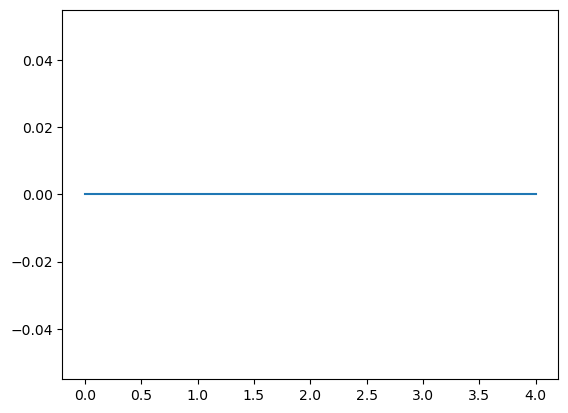

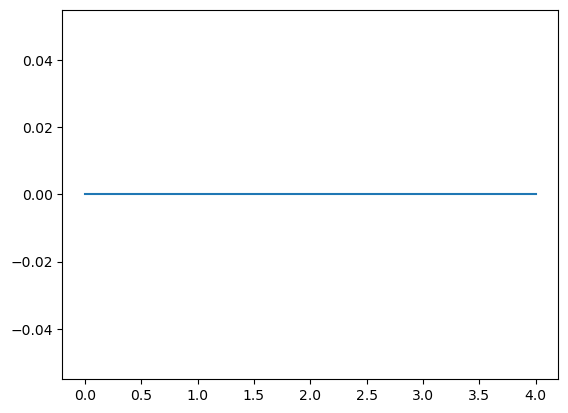

-11.863525000000003


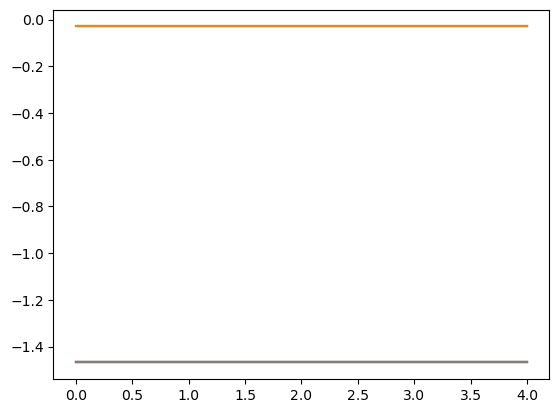

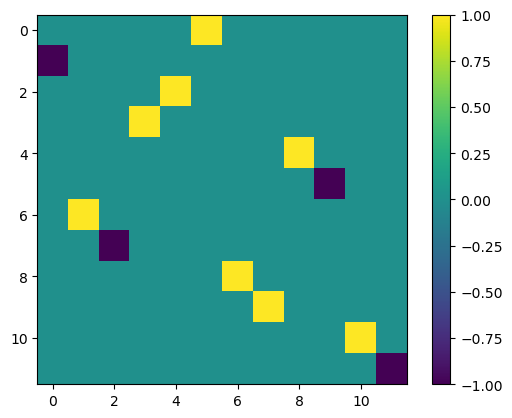

[-1.46825156 -1.46825156 -1.46825156 -1.46825156 -1.46825156 -1.46825156
 -1.46825156 -1.46825156]


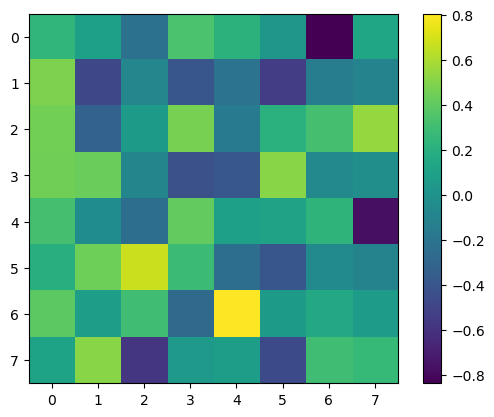

In [4]:
plt.plot(history_herm)
plt.show()

plt.plot(ortho_history)
plt.show()

energy=HFclass.compute_energy()

print(energy)

plt.plot(de)
plt.show()

plt.imshow(np.real(HFclass.weights))
plt.colorbar()
plt.show()


# check the degeneracy
print(de[0,:8])

coeff = np.random.uniform(0, 1, size=(8, 8))


ortho_coeff = gram_schmidt(coeff)

plt.imshow(ortho_coeff)
plt.colorbar()
plt.show()



In [ ]:
psi_hf = HFclass.create_hf_psi(FHHamiltonian.basis, nparticles=4)
print(psi_hf.conjugate().transpose() @ FHHamiltonian.hamiltonian @ psi_hf)

overlap_hf=[]
js = []
ms = []
for i in range(20):
    f = psi_hf.conjugate().dot(psi0[:, i]) * psi_hf.conjugate().dot(psi0[:, i]).conjugate()
    overlap_hf.append(f)
    j, m = SPS.compute_j_m_exp_value(psi=psi0[:, i], basis=FHHamiltonian.basis)
    js.append(j)
    ms.append(m)

fig, ax = plt.subplots(figsize=(10, 10))

ax_twin=ax.twinx()
ax.plot(np.arange(20),overlap_hf,color='red')
ax.scatter(np.arange(20), overlap_hf, color="red", s=40)

ax_twin.plot(np.arange(20), ms)
ax_twin.scatter(np.arange(20), ms, s=40)
ax_twin.axhline(y=0,color='green',linewidth=2,linestyle='--')
ax.tick_params(which='major',labelsize=20)
ax_twin.tick_params(which="major", labelsize=20)
ax_twin.set_ylabel(r'$m$',fontsize=40)
ax.set_ylabel(r"$|c_n|^2$", fontsize=40)
ax.set_xlabel(r'eigenstates of $H$',fontsize=40)
plt.xticks(np.arange(20),np.arange(20))
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))

ax_twin = ax.twinx()
ax.plot(np.arange(20), overlap_hf, color="red")
ax.scatter(np.arange(20), overlap_hf, color="red", s=40)

ax_twin.plot(np.arange(20), js)
ax_twin.scatter(np.arange(20), js, s=40)
ax_twin.axhline(y=0, color="green", linewidth=2, linestyle="--")
ax.tick_params(which="major", labelsize=20)
ax_twin.tick_params(which="major", labelsize=20)
ax_twin.set_ylabel(r"$j$", fontsize=40)
ax.set_ylabel(r"$|c_n|^2$", fontsize=40)
ax.set_xlabel(r"eigenstates of $H$", fontsize=40)
plt.xticks(np.arange(20), np.arange(20))
plt.show()

In [ ]:
print(np.linalg.norm(HFclass.weights[:, 0]))
print(np.sum(HFclass.weights[0, :].conj() * HFclass.weights[:, 1]))

plt.plot(de)
# plt.semilogy()
# plt.ylim([0,0.001])
plt.show()

plt.title(r'$C_{a\alpha}$',fontsize=40)
plt.imshow(np.real(HFclass.weights))
plt.xlabel(r'$a$',fontsize=40)
plt.ylabel(r"$\alpha$", fontsize=40)
plt.colorbar()
plt.show()
plt.imshow(np.imag(HFclass.weights))
plt.colorbar()
plt.show()

for i in range(energies.shape[0]//2):
    for j in range(i,energies.shape[0]//2):
        print(i,j)
        print(np.dot(HFclass.weights[:,i],b=(HFclass.weights[:,j])))

#### Minimum energy basis state initialization (Optional)

In [5]:
# old initialization works better than Hartree Fock
min = 10000
for i, b in enumerate(FHHamiltonian.basis):
    psi = np.zeros(FHHamiltonian.basis.shape[0])
    psi[i] = 1.0
    value = np.conj(psi) @ FHHamiltonian.hamiltonian @ psi
    if value < min:
        min = value
        b_min=b
        print(value)
        print(b)
        psi_base = psi

# print('min=',min)
# print(b_min)
# psi_base=np.zeros(FHHamiltonian.basis.shape[0])
# print(FHHamiltonian.basis)
# psi_base[8]=1.
# value = np.conj(psi_base) @ FHHamiltonian.hamiltonian @ psi_base
# print(value)


# overlap_base = []

# for i in range(psi0.shape[1]):
#     f = (
#         psi_base.conjugate().dot(psi0[:, i])
#         * psi_base.conjugate().dot(psi0[:, i]).conjugate()
#     )

#     overlap_base.append(f)


# fig, ax = plt.subplots(figsize=(10, 10))
# ax_twin = ax.twinx()
# ax.plot(np.arange(20), overlap_base, color="red")
# ax.scatter(np.arange(20), overlap_base, color="red", s=40)

# ax_twin.axhline(y=0, color="green", linewidth=2, linestyle="--")
# ax.tick_params(which="major", labelsize=20)
# ax_twin.tick_params(which="major", labelsize=20)
# ax_twin.set_ylabel(r"$m$", fontsize=40)
# ax.set_ylabel(r"$|c_n|^2$", fontsize=40)
# ax.set_xlabel(r"eigenstates of $H$", fontsize=40)
# plt.xticks(np.arange(20), np.arange(20))
# plt.show()

# fig, ax = plt.subplots(figsize=(10, 10))
# ax_twin = ax.twinx()
# ax.plot(np.arange(20), overlap_base, color="red")
# ax.scatter(np.arange(20), overlap_base, color="red", s=40)


# ax_twin.axhline(y=0, color="green", linewidth=2, linestyle="--")
# ax.tick_params(which="major", labelsize=20)
# ax_twin.tick_params(which="major", labelsize=20)
# ax_twin.set_ylabel(r"$j$", fontsize=40)
# ax.set_ylabel(r"$|c_n|^2$", fontsize=40)
# ax.set_xlabel(r"eigenstates of $H$", fontsize=40)
# plt.xticks(np.arange(20), np.arange(20))
# plt.show()

-5.328424999999999
[1 0 0 0 0 0 0 1 1 1 0 0]
-6.743665
[0 1 0 0 0 0 1 0 1 1 0 0]
-7.341330000000003
[0 1 0 0 0 0 0 1 1 0 0 1]
-7.341330000000003
[0 0 1 0 0 0 0 1 1 0 1 0]


#### Adapt-VQE run

In [6]:
print(FHHamiltonian.adag_adag_a_a_matrix(i1=0,i2=2,j1=1,j2=4))
for i in range(FHHamiltonian.basis.shape[0]):
    print(FHHamiltonian.basis[i,:6],FHHamiltonian.basis[i,6:],i,'\n')

print(FHHamiltonian.basis)


[1 0 0 0 0 0] [0 1 1 1 0 0] 0 

[1 0 0 0 0 0] [0 1 0 1 0 1] 1 

[1 0 0 0 0 0] [0 0 1 1 1 0] 2 

[1 0 0 0 0 0] [0 0 0 1 1 1] 3 

[0 1 0 0 0 0] [1 0 1 1 0 0] 4 

[0 1 0 0 0 0] [1 0 0 1 0 1] 5 

[0 1 0 0 0 0] [0 1 1 0 0 1] 6 

[0 1 0 0 0 0] [0 1 0 1 1 0] 7 

[0 1 0 0 0 0] [0 0 1 0 1 1] 8 

[0 0 1 0 0 0] [1 1 0 1 0 0] 9 

[0 0 1 0 0 0] [1 0 1 0 0 1] 10 

[0 0 1 0 0 0] [1 0 0 1 1 0] 11 

[0 0 1 0 0 0] [0 1 1 0 1 0] 12 

[0 0 1 0 0 0] [0 1 0 0 1 1] 13 

[0 0 0 1 0 0] [1 1 1 0 0 0] 14 

[0 0 0 1 0 0] [1 1 0 0 0 1] 15 

[0 0 0 1 0 0] [1 0 1 0 1 0] 16 

[0 0 0 1 0 0] [1 0 0 0 1 1] 17 

[0 0 0 0 1 0] [1 0 1 1 0 0] 18 

[0 0 0 0 1 0] [1 0 0 1 0 1] 19 

[0 0 0 0 1 0] [0 1 1 0 0 1] 20 

[0 0 0 0 1 0] [0 1 0 1 1 0] 21 

[0 0 0 0 1 0] [0 0 1 0 1 1] 22 

[0 0 0 0 0 1] [1 1 0 1 0 0] 23 

[0 0 0 0 0 1] [1 0 1 0 0 1] 24 

[0 0 0 0 0 1] [1 0 0 1 1 0] 25 

[0 0 0 0 0 1] [0 1 1 0 1 0] 26 

[0 0 0 0 0 1] [0 1 0 0 1 1] 27 

[[1 0 0 0 0 0 0 1 1 1 0 0]
 [1 0 0 0 0 0 0 1 0 1 0 1]
 [1 0 0 0 0 0 0 0 1 1 1 0]
 [1 

Define Miquel constrainer as a function

In [7]:
def miquel_constrainer(idxs:List[int]):
    
    if SPS.projection_conservation(idxs=idxs):
        if FHHamiltonian.charge_computation(initial_indices=idxs[:2],final_indices=idxs[2:]):
            op=FHHamiltonian.adag_adag_a_a_matrix(idxs[0],idxs[1],idxs[2],idxs[3])
            diag_op = sparse.diags(op.diagonal())

            non_diag_op =np.abs( op - diag_op)
            if not(np.isclose(non_diag_op.sum(),0.)):
                condition=True
            else:
                condition=False
        
        else:
            condition=False
    else:
        condition=False
                
    return condition


def miquel_constrainer_2(idxs:List[int]):
    _,_,j0,_,_,tz0=SPS.state_encoding[idxs[0]]
    _,_,j1,_,_,tz1=SPS.state_encoding[idxs[1]]
    _,_,j2,_,_,tz2=SPS.state_encoding[idxs[2]]
    _,_,j3,_,_,tz3=SPS.state_encoding[idxs[3]]
    
    j_tot_i = np.arange(start=int(np.abs(j0 - j1)), stop=int(j0 + j1) + 1)  # Include j0 + j1
    j_tot_f = np.arange(start=int(np.abs(j2 - j3)), stop=int(j2 + j3) + 1)  # Include j2 + j3
    #print(j_tot_i,j0,j1)
    if tz0==tz1:
        if j0==j1:
            j_tot_i=[j for j in j_tot_i if j % 2==0 ]
            #print('i=',j_tot_i,j0,j1)
        if j2==j3:
            j_tot_f=[j for j in j_tot_f if j % 2==0 ]
            #print('f=',j_tot_f,j2,j3,'\n')
        if set(j_tot_i) & set(j_tot_f):
            
            
            condition=True
        else:
            
            condition=False

    else:

       
        if set(j_tot_i) & set(j_tot_f):
            condition=True
        else:

            condition=False


            
    return condition

# print(miquel_constrainer([0,0,0,0]))

##### Set the operator pool

In [8]:
operator_pool:Dict={}

operator_pool=FHHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[SPS.projection_conservation,miquel_constrainer,miquel_constrainer_2],nbody='two')

# miquel_operator_pool=np.load('Li8_operators.npy')

# # 0    1    2    3   4   5
# # 3/2 1/2 -1/2 -3/2 1/2 -1/2 
# # -3/2 -1/2 1/2 3/2 -1/2 1/2
# translator=[3,2,1,0,5,4,9,8,7,6,11,10]

# test_op_pool=[]
# for op in miquel_operator_pool:
#     test_op_pool.append((translator[op[0]],translator[op[1]],translator[op[2]],translator[op[3]]))
    
# # print(test_op_pool)
# # print(operator_pool.keys())

# op_pool_1=list(operator_pool.keys())
# op_pool_2=test_op_pool
# print(op_pool_2[10])
# intersection = list(set(op_pool_1).intersection(op_pool_2))
# print(len(intersection)) 

# print(op_pool_1)
# excluded = list(set(op_pool_1).symmetric_difference(op_pool_2))
# print(len(excluded))

# new_operator_pool={}
# for idxs in test_op_pool:
#     op=FHHamiltonian.adag_adag_a_a_matrix(i1=idxs[0],i2=idxs[1],j1=idxs[2],j2=idxs[3])
#     op_minus=FHHamiltonian.adag_adag_a_a_matrix(i1=idxs[3],i2=idxs[2],j1=idxs[1],j2=idxs[0])
#     new_operator_pool[idxs]=op-op_minus
    
# print(len(new_operator_pool))


##### Run the ADAPT-VQE

In [9]:


# %%
random=False




model=AdaptVQEFermiHubbard()

model.set_hamiltonian(FHHamiltonian.hamiltonian)
model.set_reference_psi(psi_base,energy_gs=egs)
model.set_operators_pool(operator_pool=operator_pool,random=random)

#%%

fit=Fit(method='L-BFGS-B',tolerance_opt=10**-7)

fit.configuration_checkpoint=model.callback
fit.init_model(model)
history_energy,history_grad=fit.run()


Operator: 1 7 4 7
Optimization Success= True
weights= [-0.37051636]
energy=-8.27097
de=0.429533735
TOT_OPERATION_METRIC=11
LAYERS= 1
gradient selected= 4.78628973777077 

Operator: 7 8 8 10
Optimization Success= True
weights= [-0.42296009  0.39456297]
energy=-9.41941
de=0.350323144
TOT_OPERATION_METRIC=49
LAYERS= 2
gradient selected= 5.5100929117286475 

Operator: 1 7 5 6
Optimization Success= True
weights= [-0.38723376  0.3797726   0.26235387]
energy=-9.76928
de=0.326192010
TOT_OPERATION_METRIC=136
LAYERS= 3
gradient selected= 2.576280662837948 

Operator: 1 8 5 10
Optimization Success= True
weights= [-0.33989602  0.34422515  0.30113086  0.26022255]
energy=-10.20310
de=0.296270139
TOT_OPERATION_METRIC=280
LAYERS= 4
gradient selected= 3.214981547609372 

Operator: 0 9 1 11
Optimization Success= True
weights= [-0.35933681  0.34759803  0.27828144  0.2397284   0.2681386 ]
energy=-10.48107
de=0.277097918
TOT_OPERATION_METRIC=495
LAYERS= 5
gradient selected= 2.0320626112206277 

Operator: 6

In [8]:
print(model.operator_action_info)
translator=np.array([3,2,1,0,5,4,9,8,7,6,11,10])
# for i in range(12):
#     print(SPS.state_encoding[i],i,'\n')
    
for op in model.operator_action_info:
    print(translator[op[0]],translator[op[1]],translator[op[2]],translator[op[3]],'\n')
    

[(0, 3, 4, 5), (6, 9, 10, 11), (0, 9, 5, 10), (3, 6, 4, 11), (3, 6, 4, 8), (0, 9, 5, 7), (0, 9, 2, 10), (1, 11, 3, 6), (0, 3, 1, 2), (6, 9, 7, 8), (1, 8, 3, 6), (0, 9, 2, 7), (6, 9, 7, 11), (0, 3, 2, 4), (0, 3, 1, 5), (6, 9, 8, 10), (0, 9, 4, 11), (3, 6, 5, 10), (2, 7, 3, 6), (0, 9, 1, 8), (2, 8, 3, 10), (0, 11, 1, 7), (6, 9, 10, 11), (0, 8, 1, 10), (2, 11, 4, 9), (3, 6, 4, 11), (0, 3, 1, 2), (0, 9, 5, 10), (0, 9, 1, 11), (2, 10, 3, 6), (1, 8, 4, 8), (2, 7, 5, 7)]
3 0 5 4 

9 6 11 10 

3 6 4 11 

0 9 5 10 

0 9 5 7 

3 6 4 8 

3 6 1 11 

2 10 0 9 

3 0 2 1 

9 6 8 7 

2 7 0 9 

3 6 1 8 

9 6 8 10 

3 0 1 5 

3 0 2 4 

9 6 7 11 

3 6 5 10 

0 9 4 11 

1 8 0 9 

3 6 2 7 

1 7 0 11 

3 10 2 8 

9 6 11 10 

3 7 2 11 

1 10 5 6 

0 9 5 10 

3 0 2 1 

3 6 4 11 

3 6 2 10 

1 11 0 9 

2 7 5 7 

1 8 4 8 



In [6]:
rel_error_base = [np.abs((e_min - egs) / egs) for e_min in history_energy]

In [7]:
rel_error_hf = [np.abs((e_min - egs) / egs) for e_min in history_energy]

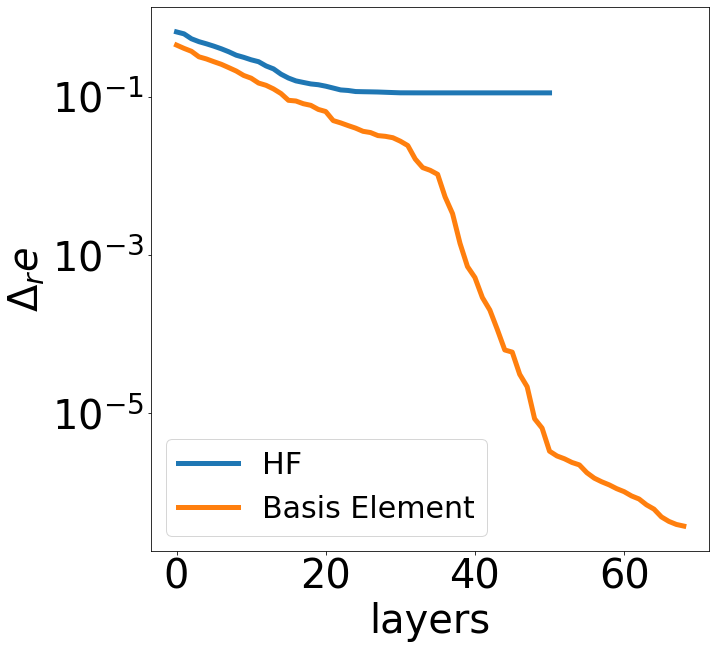

In [36]:
plt.figure(figsize=(10,10))
plt.plot(rel_error_hf,linewidth=5,label='HF')
plt.plot(rel_error_base, linewidth=5,label='Basis Element')
plt.xlabel('layers',fontsize=40)
plt.legend(fontsize=30)
plt.semilogy()
plt.ylabel(r'$\Delta_r e$',fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis="both", which="minor", labelsize=40)
plt.show()

## QAOA for Nuclear Shell Model

In [1]:
from src.hartree_fock_library import HartreeFock,HartreeFockVariational,gram_schmidt
from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict,List
from src.qml_models import QAOAFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
#from src.qml_models import AdaptVQEFermiHubbard
import matplotlib.pyplot as plt
#from adapt_vqe_old import AdaptVQEFermiHubbard

#### Parameters and Many-Body system

In [2]:
twobody_matrix,_,_,energies=get_twobody_nuclearshell_model(file_name='data/cki')

SPS=SingleParticleState(file_name='data/cki')



print(energies.shape)
print(twobody_matrix)

size_a=energies.shape[0]//2
size_b=energies.shape[0]//2
nparticles_a=2
nparticles_b=2

#%% initialize the FH Hamiltonian

FHHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,)


print(FHHamiltonian.basis.shape)



FHHamiltonian.get_external_potential(external_potential=energies)
FHHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
FHHamiltonian.get_hamiltonian()

es,psi0=FHHamiltonian.get_spectrum(n_states=20)
egs=es[0]
e1st=es[1]
print(egs,e1st)








   0 1   103 103 103 103    0    3     

     0.0000   -3.1398     0.0000   -6.6779

   -2.7352     0.0000    -0.6490     0.0000

   0 1   103 103 103 101    1    2

    4.0238     0.0000

     0.0000   -2.2055

   0 1   103 103 101 101    0    1

     0.0000    1.0893

   -5.3229     0.0000

   0 1   103 101 103 101    1    2

   -6.5365   -4.2246

     0.8630   -1.1408

   0 1   103 101 101 101    1    1

    1.3920

     0.0000

   0 1   101 101 101 101    0    1

     0.0000   -4.2568

     0.3397     0.0000

-4.0238
0.0
0.0
2.2055
6.5365
0.863
-4.2246
1.1408
[1.63, 2.27]


100%|██████████| 12/12 [00:02<00:00,  4.23it/s]


[1.63, 2.27]
(12,)
{(0, 1, 0, 1): -0.6490000000000002, (0, 1, 1, 0): 0.6490000000000002, (1, 0, 0, 1): 0.6490000000000002, (1, 0, 1, 0): -0.6490000000000002, (0, 1, 0, 4): 2.2055000000000007, (0, 1, 4, 0): -2.2055000000000007, (1, 0, 0, 4): -2.2055000000000007, (1, 0, 4, 0): 2.2055000000000007, (0, 2, 0, 2): -0.6490000000000002, (0, 2, 2, 0): 0.6490000000000002, (2, 0, 0, 2): 0.6490000000000002, (2, 0, 2, 0): -0.6490000000000002, (0, 2, 0, 5): 1.1027500000000003, (0, 2, 5, 0): -1.1027500000000003, (2, 0, 0, 5): -1.1027500000000003, (2, 0, 5, 0): 1.1027500000000003, (0, 2, 1, 4): 1.91001902804658, (0, 2, 4, 1): -1.91001902804658, (2, 0, 1, 4): -1.91001902804658, (2, 0, 4, 1): 1.91001902804658, (0, 3, 0, 3): -1.6921, (0, 3, 3, 0): 1.6921, (3, 0, 0, 3): 1.6921, (3, 0, 3, 0): -1.6921, (0, 3, 1, 2): 1.0430999999999995, (0, 3, 2, 1): -1.0430999999999995, (3, 0, 1, 2): -1.0430999999999995, (3, 0, 2, 1): 1.0430999999999995, (0, 3, 1, 5): 1.1027500000000001, (0, 3, 5, 1): -1.1027500000000001, (

#### Driving Hamiltonian

In [3]:
t=3.
DrivingHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a,size_a))
for i in range(size_a):
    for j in range(size_a):
        (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
        (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
        if np.isclose(mi,-mj) and np.isclose(ni,nj):
            kinetic_term[(i,j)]=t #np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=t#np.abs(mi-mj)#+np.abs(ji-jj)
            if size_b==size_a:    
                kinetic_term[(size_a +i,size_a+j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
                
# external_field=np.zeros(size_a+size_b)
# for i in range(size_a+size_b):
#     (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
#     external_field[i]=2*ji
    
    #external_field[i] = SPS.energies[i]


DrivingHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
#DrivingHamiltonian.get_external_potential(external_field)
DrivingHamiltonian.get_hamiltonian()

egs,reference_psi=DrivingHamiltonian.get_spectrum(n_states=1)
print(egs)

[-36.]


#### QAOA run

In [4]:



model=QAOAFermiHubbard()

model.set_hamiltonian(FHHamiltonian.hamiltonian,DrivingHamiltonian.hamiltonian)
model.set_reference_psi(reference_psi=reference_psi)
model.set_weights(total_step=100,initialization_type='annealing',tf=30)

print(model.weights.shape)
#%%

fit=Fit(method='BFGS',tolerance_opt=10**-6)

fit.configuration_checkpoint=configuration
fit.init_model(model)
history_energy,history_grad=fit.run()
print(model.weights)

(20,)
energy value= -10.151053733771933 

energy value= -10.71386850508635 

energy value= -11.570408448620741 

energy value= -11.666962924882117 

energy value= -11.77645191807727 

energy value= -12.240019898810338 

energy value= -12.438744238711156 

energy value= -12.553616690684153 

energy value= -12.626004928416737 

energy value= -12.685180668333167 

energy value= -12.720216722989608 

energy value= -12.726317929973236 

energy value= -12.737312773970514 

energy value= -12.75693014381353 

energy value= -12.898491911720594 

energy value= -12.979930877233864 

energy value= -12.988807731702735 

energy value= -13.259685776315958 

energy value= -13.27299023399189 

energy value= -13.39324180852665 

energy value= -13.565006025546268 

energy value= -13.768505382406223 

energy value= -13.85914887129935 

energy value= -13.998420637496714 

energy value= -14.233548927790965 

energy value= -14.685814035355744 

energy value= -14.874837865513046 

energy value= -14.9058038207

In [ ]:
rel_error_base = [np.abs((e_min - egs) / egs) for e_min in history_energy]

In [ ]:
rel_error_hf = [np.abs((e_min - egs) / egs) for e_min in history_energy]

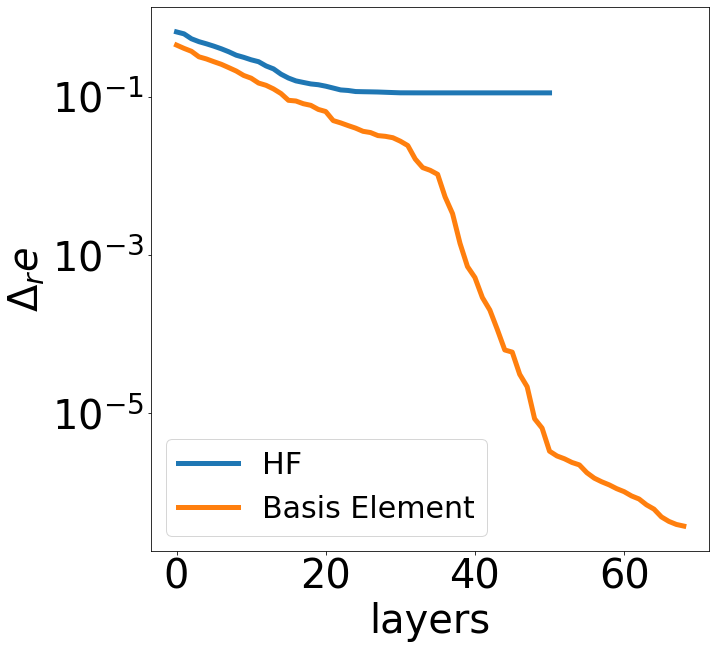

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(rel_error_hf,linewidth=5,label='HF')
plt.plot(rel_error_base, linewidth=5,label='Basis Element')
plt.xlabel('layers',fontsize=40)
plt.legend(fontsize=30)
plt.semilogy()
plt.ylabel(r'$\Delta_r e$',fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis="both", which="minor", labelsize=40)
plt.show()